# Modeling with k-fold cross validation

Given 10+ stories per categories, create a model and use 5-fold cross validation to predict story categories
The model can be a neural network, so we will have confidences, or multinomial regression, in both cases we offer potential alternative categories, because multiple categories could represent a given story

## Preprocessing data
- Add super categories

In [44]:
import json
with open('Downloads/ATU.jl') as f:
    df_li = []
    for line in f:
        j = json.loads(line)
        df_li.append(j)
        
df = pd.DataFrame(df_li)
df

<IPython.core.display.Javascript object>

,atu,desc,title,origin,text,url
0,1,The theft of fish,Reynard Steals Fish,Joseph Jacobs,"Reynard saw a man driving a cart full of fish,...",http://www.pitt.edu/~dash/type0001.html
1,1,The theft of fish,Two Foxes Steal Herrings,Scotland,A man was one day walking along the road with ...,http://www.pitt.edu/~dash/type0001.html
2,1,The theft of fish,The Fox and the Lapp,Andrew Lang,Once upon a time a fox lay peeping out of his ...,http://www.pitt.edu/~dash/type0001.html
3,1,The theft of fish,"Mr. Fox Goes a-Hunting, but Mr. Rabbit Bags th...",Joel Chandler Harris,One day Brer Fox came along all rigged out and...,http://www.pitt.edu/~dash/type0001.html
4,1,The theft of fish,How Brother Fox Was Too Smart,Joel Chandler Harris,One day Brer Fox heard Mr. Man coming down the...,http://www.pitt.edu/~dash/type0001.html
...,...,...,...,...,...,...
1553,2250,Unfinished tales,The Story That Never Ends,Czechoslovakia,Once upon a time there was a shepherd who had ...,http://www.pitt.edu/~dash/type2250.html
1554,2250,Unfinished tales,A Storyteller of Messer Azzolino,Italy,Messer Azzolino had a storyteller whom he made...,http://www.pitt.edu/~dash/type2250.html
1555,2250,Unfinished tales,The Treasure,Italy,Once upon a time there was a prince who studie...,http://www.pitt.edu/~dash/type2250.html
1556,2250,Unfinished tales,The Shepherd,Italy,Once upon a time there was a shepherd who went...,http://www.pitt.edu/~dash/type2250.html


In [2]:
import numpy as np
df['super_category'] = pd.cut(df['atu'].str.extract('(\d+)').astype(int).squeeze(), # extract numbers and convert dtype to int
                              [-1, 299, 749, 849, 999, 1199, 1999, 2399],
                              labels=['ANIMAL TALES', # (-1, 299]
                                      'TALES OF MAGIC', # (299, 749]
                                      'RELIGIOUS TALES', # ...
                                      'REALISTIC TALES',
                                      'TALES OF THE STUPID OGRE (GIANT, DEVIL)',
                                      'ANECDOTES AND JOKES',
                                      'FORMULA TALES'])

<IPython.core.display.Javascript object>

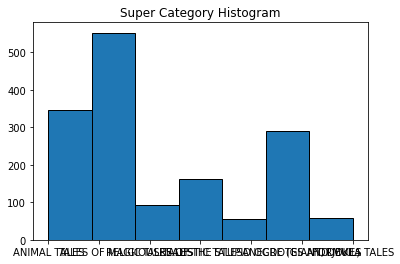

In [133]:
ax = df['super_category'].hist(bins=df['super_category'].nunique(), ec='black')
ax.grid(False)
ax.title.set_text('Super Category Histogram')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

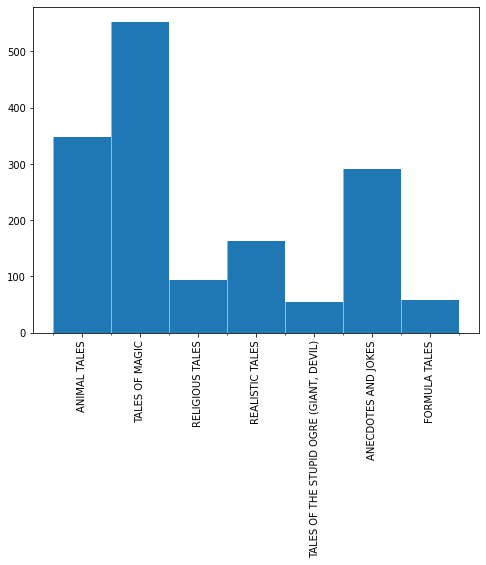

In [161]:
from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(df['super_category'], bins=7)
# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
xticks_labels = [ value for idx, value in enumerate(df['super_category'].unique())]
plt.xticks(xticks, labels = xticks_labels, rotation=90)
plt.show()

In [149]:
[ (idx,value) for idx, value in enumerate(df['super_category'].unique())]

[(0, 'ANIMAL TALES'),
 (1, 'TALES OF MAGIC'),
 (2, 'RELIGIOUS TALES'),
 (3, 'REALISTIC TALES'),
 (4, 'TALES OF THE STUPID OGRE (GIANT, DEVIL)'),
 (5, 'ANECDOTES AND JOKES'),
 (6, 'FORMULA TALES')]

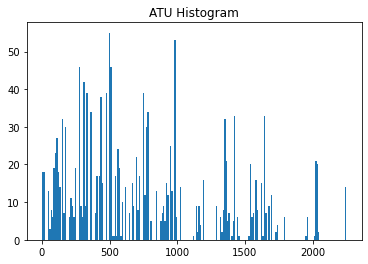

In [49]:
data = df['atu'].str.extract('(\d+)').astype(int).squeeze()
ax = data.hist(bins=data.nunique())
ax.grid(False)
ax.title.set_text('ATU Histogram')

In [127]:
df['super_category'] = pd.Categorical(df['super_category'])
df['super_category_codes'] = df['super_category'].cat.codes
df['super_category']

<IPython.core.display.Javascript object>

0        ANIMAL TALES
1        ANIMAL TALES
2        ANIMAL TALES
3        ANIMAL TALES
4        ANIMAL TALES
            ...      
1553    FORMULA TALES
1554    FORMULA TALES
1555    FORMULA TALES
1556    FORMULA TALES
1557    FORMULA TALES
Name: super_category, Length: 1558, dtype: category
Categories (7, object): ['ANIMAL TALES' < 'TALES OF MAGIC' < 'RELIGIOUS TALES' < 'REALISTIC TALES' < 'TALES OF THE STUPID OGRE (GIANT, DEVIL)' < 'ANECDOTES AND JOKES' < 'FORMULA TALES']

In [1]:
df = pd.read_pickle('Downloads/ATUwithLF.pkl')

<IPython.core.display.Javascript object>

## Improved longformer
- Used longformer-large-4096
- Pytorch implementation
- introducing batch size and torch.no_grad() to better use of GPU memory which greatly reduced the chance of OOM error
- Uses larger dimension, 1024 instead of 768

In [4]:
import torch
def pad_to_window_size(input_ids: torch.Tensor, attention_mask: torch.Tensor,
                       one_sided_window_size: int, pad_token_id: int):
    '''A helper function to pad tokens and mask to work with the sliding_chunks implementation of Longformer selfattention.
    Input:
        input_ids = torch.Tensor(bsz x seqlen): ids of wordpieces
        attention_mask = torch.Tensor(bsz x seqlen): attention mask
        one_sided_window_size = int: window size on one side of each token
        pad_token_id = int: tokenizer.pad_token_id
    Returns
        (input_ids, attention_mask) padded to length divisible by 2 * one_sided_window_size
    '''
    import torch.nn.functional as F
    w = int(2 * one_sided_window_size)
    seqlen = input_ids.size(1)
    padding_len = (w - seqlen % w) % w
    input_ids = F.pad(input_ids, (0, padding_len), value=pad_token_id)
    attention_mask = F.pad(attention_mask, (0, padding_len), value=False)  # no attention on the padding tokens
    return input_ids, attention_mask

In [5]:
import torch, gc
from transformers import TFLongformerModel, LongformerTokenizerFast, LongformerConfig
from transformers import RobertaTokenizer, LongformerModel
from transformers import AutoTokenizer, AutoModel

config = LongformerConfig.from_pretrained('allenai/longformer-large-4096')
# choose the attention mode 'n2', 'tvm' or 'sliding_chunks'
# 'n2': for regular n2 attantion
# 'tvm': a custom CUDA kernel implementation of our sliding window attention
# 'sliding_chunks': a PyTorch implementation of our sliding window attention
config.attention_mode = 'tvm'

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-large-4096")
model = AutoModel.from_pretrained("allenai/longformer-large-4096")
tokenizer.model_max_length = model.config.max_position_embeddings

model = model.cuda();

def LFencode(row):
    TEXT = row['text']
    input_ids = torch.tensor(tokenizer.encode(TEXT, max_length=4096, truncation=True)).unsqueeze(0) # batch of size 1

    # TVM code doesn't work on CPU. Uncomment this if `config.attention_mode = 'tvm'`
    input_ids = input_ids.cuda()

    # Attention mask values -- 0: no attention, 1: local attention, 2: global attention
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device) # initialize to local attention
#     attention_mask[:, [1, 4, 21,]] =  2  # Set global attention based on the task. For example,
                                         # classification: the <s> token
                                         # QA: question tokens

    # padding seqlen to the nearest multiple of 512. Needed for the 'sliding_chunks' attention
    input_ids, attention_mask = pad_to_window_size(
            input_ids, attention_mask, config.attention_window[0], tokenizer.pad_token_id)

    output = model(input_ids, attention_mask=attention_mask)

    result = output.pooler_output.cpu()
    
    return result.detach().numpy() # tensor to numpy

In [6]:
from tqdm.notebook import tqdm
tqdm.pandas()
# df['longformer_output'] = df.progress_apply(LFencode,axis=1)

import time

batch_size = 16
result = []
for batch_number, batch_df in tqdm(df.groupby(np.arange(len(df)) // batch_size)):
    # result.append(batch_df['ID'].nunique())
    with torch.no_grad(): # VERY IMPORTANT to have this, this clears the memory of every batch apply
        batch_df['longformer_output'] = batch_df.apply(LFencode, axis=1)
    result.append(batch_df)

  0%|          | 0/98 [00:00<?, ?it/s]

In [12]:
df = pd.concat(result)

<IPython.core.display.Javascript object>

In [16]:
df.to_pickle('Downloads/ATUwithLF.pkl')

## 5-fold Cross Validation - Neural Nets

In [2]:
X = np.concatenate(df['longformer_output'].to_numpy())
y = df['super_category_codes'].to_numpy()

<IPython.core.display.Javascript object>

In [3]:
print(X.shape)
print(y.shape)

(1558, 1024)
(1558,)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X)

print(scaled_X, y)

[[0.4283533  0.40000248 0.23964429 ... 0.48592663 0.4139542  0.32341695]
 [0.49106818 0.50427806 0.38821864 ... 0.33221245 0.3870903  0.43134838]
 [0.48769316 0.21859753 0.2861817  ... 0.3809061  0.5470168  0.45680666]
 ...
 [0.6460567  0.3823918  0.4386909  ... 0.46167827 0.31094456 0.37116343]
 [0.41123998 0.37448668 0.36525416 ... 0.41871262 0.44636244 0.3154747 ]
 [0.62211263 0.41466892 0.5272293  ... 0.44343853 0.34853104 0.38825452]] [0 0 0 ... 6 6 6]


### Dealing with imbalanced data
Solution: Using different metrics

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.5)

In [6]:
print(X_train.shape, X_test.shape, X_eval.shape)
print(y_train.shape, y_test.shape, y_eval.shape)

(1246, 1024) (156, 1024) (156, 1024)
(1246,) (156,) (156,)


I give up on the following cell...

In [7]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
import tensorflow.keras as keras
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    keras.metrics.SparseCategoricalAccuracy(name='sparse_cat_accuracy'),
    keras.metrics.TopKCategoricalAccuracy(name='top_k', k=5),
    f1
#     PRE_micro,
#     PRE_macro
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    n_cat = df['super_category_codes'].nunique()
    model = keras.Sequential([
        keras.layers.Dense(
            768, activation='relu',
            input_shape=(X_train.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(7, activation='relu'),
        keras.layers.Dense(n_cat, activation='softmax',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=METRICS)

    return model

In [9]:
df['super_category_codes'].nunique()

7

In [10]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='f1', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

<IPython.core.display.Javascript object>

### Without init bias

In [11]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 768)               787200    
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               393728    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 56        
Total params: 1,247,551
Trainable params: 1,247,551
Non-trainable params: 0
______________________________________________

In [12]:
model.predict(X_train[:10])

array([[0.16619445, 0.16005711, 0.09515496, 0.09313602, 0.17830901,
        0.07158539, 0.23556307],
       [0.18351337, 0.14966878, 0.11254904, 0.08995315, 0.17529052,
        0.07924186, 0.20978321],
       [0.17389424, 0.15595374, 0.10442132, 0.09341401, 0.17385565,
        0.07539152, 0.22306958],
       [0.17279094, 0.15560538, 0.10395287, 0.09054197, 0.17785867,
        0.07505967, 0.22419046],
       [0.15984805, 0.15441726, 0.09667192, 0.09490881, 0.17136967,
        0.0709114 , 0.2518729 ],
       [0.15782255, 0.1586021 , 0.0959175 , 0.09591958, 0.17895433,
        0.07383339, 0.23895045],
       [0.15891217, 0.16036332, 0.09607813, 0.09334528, 0.17097446,
        0.06882756, 0.25149912],
       [0.17365734, 0.15899558, 0.1051111 , 0.09254802, 0.1696567 ,
        0.07288765, 0.22714363],
       [0.17445725, 0.15967445, 0.10461501, 0.09191887, 0.16792355,
        0.0714283 , 0.22998255],
       [0.17886668, 0.15523182, 0.10807554, 0.0967759 , 0.15585496,
        0.07120132, 0.2

In [13]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
import math
print("With the default bias initialization the loss should be about", -math.log(1/7))
print("Loss: {:0.4f}".format(results[0]))

With the default bias initialization the loss should be about 1.9459101490553135
Loss: 2.0404


In [14]:
def as_perc(value, total):
    return value/float(total)

grouped_count = df.groupby(['super_category_codes']).size()
initial_bias = grouped_count.apply(as_perc, total=df['super_category_codes'].count()).to_numpy()

### With init bias

In [15]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

<IPython.core.display.Javascript object>

array([[0.19096453, 0.10575305, 0.17690384, 0.08216934, 0.20456658,
        0.10374679, 0.13589588],
       [0.1706677 , 0.11476849, 0.18763666, 0.08977364, 0.17753868,
        0.11938189, 0.14023298],
       [0.18326998, 0.11100608, 0.17785339, 0.08026547, 0.20000449,
        0.10797773, 0.13962285],
       [0.18923348, 0.11423152, 0.17051475, 0.0875806 , 0.18370852,
        0.11230435, 0.1424267 ],
       [0.18042834, 0.12089681, 0.16914509, 0.08556965, 0.19081706,
        0.11336347, 0.13977955],
       [0.18170656, 0.12005426, 0.17013663, 0.0863148 , 0.17889275,
        0.1167639 , 0.14613105],
       [0.19149649, 0.10777512, 0.17762826, 0.08155143, 0.1897676 ,
        0.10880373, 0.14297737],
       [0.18689804, 0.11288752, 0.17288733, 0.08104543, 0.19741324,
        0.10830344, 0.14056498],
       [0.19187187, 0.12292738, 0.15965119, 0.08625542, 0.17966025,
        0.1146071 , 0.14502683],
       [0.19733217, 0.09721798, 0.1848197 , 0.08089922, 0.19393955,
        0.10347824, 0.1

In [16]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.0704


In [17]:
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

<IPython.core.display.Javascript object>

In [18]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign(np.zeros(7))
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_eval, y_eval), 
    verbose=0)

<IPython.core.display.Javascript object>

In [19]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_eval, y_eval), 
    verbose=0)

In [20]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

<IPython.core.display.Javascript object>

In [21]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [22]:
colors[0]

'#1f77b4'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

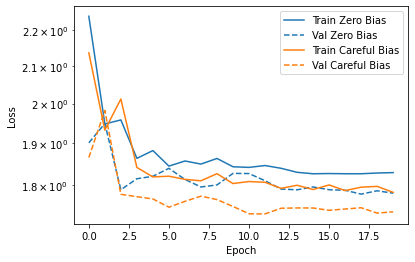

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

### Train the model

In [24]:
model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=early_stopping,
    validation_data=(X_eval, y_eval))

Epoch 1/100
1/1 [==============================] - 0s 38ms/step - loss: 1.7776 - accuracy: 0.2167 - cat_accuracy: 0.0072 - sparse_cat_accuracy: 0.3587 - top_k: 1.0000 - f1: 3.7193 - val_loss: 1.7454 - val_accuracy: 0.2756 - val_cat_accuracy: 0.0000e+00 - val_sparse_cat_accuracy: 0.3718 - val_top_k: 1.0000 - val_f1: 3.5752
Epoch 2/100
1/1 [==============================] - 0s 18ms/step - loss: 1.7851 - accuracy: 0.2167 - cat_accuracy: 0.0080 - sparse_cat_accuracy: 0.3547 - top_k: 1.0000 - f1: 3.7357 - val_loss: 1.7432 - val_accuracy: 0.2756 - val_cat_accuracy: 0.0128 - val_sparse_cat_accuracy: 0.3654 - val_top_k: 1.0000 - val_f1: 3.4513
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 1.7768 - accuracy: 0.2167 - cat_accuracy: 0.0546 - sparse_cat_accuracy: 0.3531 - top_k: 1.0000 - f1: 3.8627 - val_loss: 1.7327 - val_accuracy: 0.2756 - val_cat_accuracy: 0.1218 - val_sparse_cat_accuracy: 0.4038 - val_top_k: 1.0000 - val_f1: 3.6991
Epoch 4/100
1/1 [===================

## 5-fold

In [25]:
X = np.concatenate(df['longformer_output'].to_numpy())
y = df['super_category_codes'].to_numpy()

<IPython.core.display.Javascript object>

### Neural Nets

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(scaled_X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=100,
        verbose=0,
        callbacks=early_stopping,
    )
    model.evaluate(X_test, y_test)

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
10/10 [==============================] - 0s 1ms/step - loss: 1.7334 - accuracy: 0.2244 - cat_accuracy: 0.0641 - sparse_cat_accuracy: 0.3654 - top_k: 1.0000 - f1: 3.0480
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
10/10 [==============================] - 0s 1ms/step - loss: 1.6698 - accuracy: 0.2248 - cat_accuracy: 0.1699 - sparse_cat_accuracy: 0.4038 - top_k: 1.0000 - f1: 3.0863
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
10/10 [==============================] - 0s 2ms/step - loss: 1.6140 - accuracy: 0.2331 - cat_accuracy: 0.1250 - sparse_cat_accuracy: 0.4071 - top_k: 1.0000 - f1: 3.2573
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
10/10 [==============================] - 0s 1ms/step - loss: 1.6756 - accuracy: 0.2219 - cat_accuracy: 0.3023 - sparse_cat_accuracy: 0.4277 - top_k: 1.0000 -

### Logistic Regression

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from numpy import mean
from numpy import std

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X)

model = LogisticRegression(multi_class='multinomial',
                           solver='lbfgs',
                           class_weight='balanced',
                          max_iter=4000,
                          n_jobs=-1)

In [122]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, scaled_X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.524 (0.027)


In [123]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=4000,
                   multi_class='multinomial', n_jobs=-1)

In [124]:
model.predict(X_test)

array([0, 4, 0, 2, 6, 6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 6, 6, 3, 0, 5, 0, 0, 5, 2, 0, 0, 5, 0, 1, 2, 1,
       0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 4, 1, 0, 2, 2, 4, 1, 1, 3, 1,
       3, 6, 5, 2, 2, 4, 1, 1, 5, 1, 1, 1, 1, 1, 5, 0, 5, 5, 1, 1, 1, 1,
       1, 2, 4, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 4, 1, 1, 3, 4, 1, 6, 1, 1,
       2, 1, 3, 1, 2, 2, 1, 2, 1, 3, 1, 1, 3, 3, 1, 1, 1, 5, 1, 1, 1, 1,
       5, 1, 4, 1, 1, 1, 3, 2, 3, 1, 1, 4, 1, 1, 3, 5, 2, 3, 1, 2, 3, 4,
       2, 3, 1, 3, 2, 1, 5, 5, 2, 2, 3, 1, 1, 2, 2, 2, 1, 2, 3, 3, 3, 3,
       3, 3, 1, 3, 5, 6, 1, 0, 3, 2, 3, 1, 1, 1, 5, 5, 3, 5, 5, 1, 4, 3,
       3, 2, 0, 3, 3, 2, 4, 2, 0, 0, 5, 1, 2, 2, 4, 0, 0, 4, 4, 5, 2, 5,
       5, 5, 6, 4, 3, 4, 6, 5, 5, 6, 3, 5, 5, 0, 0, 3, 1, 2, 5, 1, 5, 3,
       6, 5, 5, 5, 0, 6, 1, 3, 3, 6, 4, 5, 6, 2, 0, 3, 5, 4, 2, 4, 3, 5,
       5, 1, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 4, 0, 6,

In [125]:
model.score(X_test, y_test)

0.5080385852090032

In [126]:
model.score(X_eval, y_eval)

0.14743589743589744